### Importing Necessary Libraries


In [ ]:
# --- LangChain and LLM Imports ---
from langchain_openai import ChatOpenAI 
from langchain_groq import ChatGroq

# --- Document Loading and Vector Store ---
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings 

# --- Prompting and Document Utilities ---
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain

# --- Core and Output Parsers ---
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod

# --- LangGraph for Workflow Graphs ---
from langgraph.graph import END, StateGraph

# --- Standard Library Imports ---
from time import monotonic
from dotenv import load_dotenv
from pprint import pprint
import os

# --- Datasets and Typing ---
from datasets import Dataset
from typing_extensions import TypedDict
from IPython.display import display, Image
from typing import List, TypedDict

# --- RAGAS Metrics for Evaluation ---
from ragas import evaluate
from ragas.metrics import (
    answer_correctness,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_similarity
)

import langgraph

# --- Helper Functions ---
from helper_functions import (
    num_tokens_from_string,
    replace_t_with_space,
    replace_double_lines_with_one_line,
    split_into_chapters,
    analyse_metric_results,
    escape_quotes,
    text_wrap,
    extract_book_quotes_as_documents
)

# --- Load environment variables (e.g., API keys) ---
load_dotenv(override=True)

# --- Set environment variable for debugging (optional) ---
os.environ["PYDEVD_WARN_EVALUATION_TIMEOUT"] = "100000"

### Setting OPENAI and GROQ API keys

In [ ]:
# --- Set API Keys for OpenAI and Groq ---

# Set the OpenAI API key from environment variable (for use by OpenAI LLMs)
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

# Retrieve the Groq API key from environment variable (for use by Groq LLMs)
groq_api_key = os.getenv('GROQ_API_KEY')

# Data preprocessing

### Defining Path to Harry Potter PDF


In [ ]:
# Define the path to the Harry Potter PDF file.
# This variable will be used throughout the notebook for loading and processing the book.
hp_pdf_path = "Harry_Potter_Book_1_The_Sorcerers_Stone.pdf"

### Splitting the PDF into Chapters and Preprocessing


In [ ]:
# --- Split the PDF into chapters and preprocess the text ---

# 1. Split the PDF into chapters using the provided helper function.
#    This function takes the path to the PDF and returns a list of Document objects, each representing a chapter.
chapters = split_into_chapters(hp_pdf_path)

# 2. Clean up the text in each chapter by replacing unwanted characters (e.g., '\t') with spaces.
#    This ensures the text is consistent and easier to process downstream.
chapters = replace_t_with_space(chapters)

# 3. Print the number of chapters extracted to verify the result.
print(len(chapters))

17


### Creating a list of quotes taken from the book

In [ ]:
# --- Load and Preprocess the PDF, then Extract Quotes ---

# 1. Load the PDF using PyPDFLoader
loader = PyPDFLoader(hp_pdf_path)
document = loader.load()

# 2. Clean the loaded document by replacing unwanted characters (e.g., '\t') with spaces
document_cleaned = replace_t_with_space(document)

# 3. Extract a list of quotes from the cleaned document as Document objects
book_quotes_list = extract_book_quotes_as_documents(document_cleaned)

### Defining Prompt Template for Summarization


In [ ]:
# --- Summarization Prompt Template for LLM-based Summarization ---

# Define the template string for summarization.
# This template instructs the language model to write an extensive summary of the provided text.
summarization_prompt_template = """Write an extensive summary of the following:

{text}

SUMMARY:"""

# Create a PromptTemplate object using the template string.
# The input variable "text" will be replaced with the content to summarize.
summarization_prompt = PromptTemplate(
    template=summarization_prompt_template,
    input_variables=["text"]
)

### Defining Function to Create Chapter Summaries using LLMs


In [ ]:
def create_chapter_summary(chapter):
    """
    Creates a summary of a chapter using a large language model (LLM).

    Args:
        chapter: A Document object representing the chapter to summarize.

    Returns:
        A Document object containing the summary of the chapter.
    """

    # Extract the text content from the chapter
    chapter_txt = chapter.page_content

    # Specify the LLM model and configuration
    model_name = "gpt-3.5-turbo-0125"
    llm = ChatOpenAI(temperature=0, model_name=model_name)
    gpt_35_turbo_max_tokens = 16000  # Maximum token limit for the model
    verbose = False  # Set to True for more detailed output

    # Calculate the number of tokens in the chapter text
    num_tokens = num_tokens_from_string(chapter_txt, model_name)

    # Choose the summarization chain type based on token count
    if num_tokens < gpt_35_turbo_max_tokens:
        # For shorter chapters, use the "stuff" chain type
        chain = load_summarize_chain(
            llm,
            chain_type="stuff",
            prompt=summarization_prompt,
            verbose=verbose
        )
    else:
        # For longer chapters, use the "map_reduce" chain type
        chain = load_summarize_chain(
            llm,
            chain_type="map_reduce",
            map_prompt=summarization_prompt,
            combine_prompt=summarization_prompt,
            verbose=verbose
        )

    # Start timer to measure summarization time
    start_time = monotonic()

    # Create a Document object for the chapter
    doc_chapter = Document(page_content=chapter_txt)

    # Generate the summary using the selected chain
    summary_result = chain.invoke([doc_chapter])

    # Print chain type and execution time for reference
    print(f"Chain type: {chain.__class__.__name__}")
    print(f"Run time: {monotonic() - start_time}")

    # Clean up the summary text (remove double newlines, etc.)
    summary_text = replace_double_lines_with_one_line(summary_result["output_text"])

    # Create a Document object for the summary, preserving chapter metadata
    doc_summary = Document(page_content=summary_text, metadata=chapter.metadata)

    return doc_summary

### Generating Summaries for Each Chapter


In [ ]:
# --- Generate Summaries for Each Chapter ---

# Initialize an empty list to store the summaries of each chapter
chapter_summaries = []

# Iterate over each chapter in the chapters list
for chapter in chapters:
    # Generate a summary for the current chapter using the create_chapter_summary function
    summary = create_chapter_summary(chapter)
    # Append the summary to the chapter_summaries list
    chapter_summaries.append(summary)

# Encoding the data

### Function to Encode a Book into a Vector Store using OpenAI Embeddings


In [ ]:
def encode_book(path, chunk_size=1000, chunk_overlap=200):
    """
    Encodes a PDF book into a FAISS vector store using OpenAI embeddings.

    Args:
        path (str): The path to the PDF file.
        chunk_size (int): The desired size of each text chunk.
        chunk_overlap (int): The amount of overlap between consecutive chunks.

    Returns:
        FAISS: A FAISS vector store containing the encoded book content.
    """

    # 1. Load the PDF document using PyPDFLoader
    loader = PyPDFLoader(path)
    documents = loader.load()

    # 2. Split the document into chunks for embedding
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len
    )
    texts = text_splitter.split_documents(documents)

    # 3. Clean up the text chunks (replace unwanted characters)
    cleaned_texts = replace_t_with_space(texts)

    # 4. Create OpenAI embeddings and encode the cleaned text chunks into a FAISS vector store
    embeddings = OpenAIEmbeddings()
    vectorstore = FAISS.from_documents(cleaned_texts, embeddings)

    # 5. Return the vector store
    return vectorstore

### Encoding Chapter Summaries into Vector Store


In [ ]:
def encode_chapter_summaries(chapter_summaries):
    """
    Encodes a list of chapter summaries into a FAISS vector store using OpenAI embeddings.

    Args:
        chapter_summaries (list): A list of Document objects representing the chapter summaries.

    Returns:
        FAISS: A FAISS vector store containing the encoded chapter summaries.
    """
    # Create OpenAI embeddings instance
    embeddings = OpenAIEmbeddings()
    
    # Encode the chapter summaries into a FAISS vector store
    chapter_summaries_vectorstore = FAISS.from_documents(chapter_summaries, embeddings)
    
    # Return the vector store
    return chapter_summaries_vectorstore

### Encoding Quotes into Vector Store

In [ ]:
def encode_quotes(book_quotes_list):
    """
    Encodes a list of book quotes into a FAISS vector store using OpenAI embeddings.

    Args:
        book_quotes_list (list): A list of Document objects, each representing a quote from the book.

    Returns:
        FAISS: A FAISS vector store containing the encoded book quotes.
    """
    # Create OpenAI embeddings instance
    embeddings = OpenAIEmbeddings()
    
    # Encode the book quotes into a FAISS vector store
    quotes_vectorstore = FAISS.from_documents(book_quotes_list, embeddings)
    
    # Return the vector store
    return quotes_vectorstore

# Creating vector stores and retrievers 

### Creating Vector Stores and Retrievers for Book and Chapter Summaries


In [ ]:
# --- Create or Load Vector Stores for Book Chunks, Chapter Summaries, and Book Quotes ---

# Check if the vector stores already exist on disk
if (
    os.path.exists("chunks_vector_store") and
    os.path.exists("chapter_summaries_vector_store") and
    os.path.exists("book_quotes_vectorstore")
):
    # If vector stores exist, load them using OpenAI embeddings
    embeddings = OpenAIEmbeddings()
    chunks_vector_store = FAISS.load_local(
        "chunks_vector_store", embeddings, allow_dangerous_deserialization=True
    )
    chapter_summaries_vector_store = FAISS.load_local(
        "chapter_summaries_vector_store", embeddings, allow_dangerous_deserialization=True
    )
    book_quotes_vectorstore = FAISS.load_local(
        "book_quotes_vectorstore", embeddings, allow_dangerous_deserialization=True
    )
else:
    # If vector stores do not exist, encode and save them

    # 1. Encode the book into a vector store of chunks
    chunks_vector_store = encode_book(hp_pdf_path, chunk_size=1000, chunk_overlap=200)

    # 2. Encode the chapter summaries into a vector store
    chapter_summaries_vector_store = encode_chapter_summaries(chapter_summaries)

    # 3. Encode the book quotes into a vector store
    book_quotes_vectorstore = encode_quotes(book_quotes_list)

    # 4. Save the vector stores to disk for future use
    chunks_vector_store.save_local("chunks_vector_store")
    chapter_summaries_vector_store.save_local("chapter_summaries_vector_store")
    book_quotes_vectorstore.save_local("book_quotes_vectorstore")

### Create retrievers from the vector stores

In [ ]:
# --- Create Query Retrievers from Vector Stores ---

# The following retrievers are used to fetch relevant documents from the vector stores
# based on a query. The number of results returned can be controlled via the 'k' parameter.

# Retriever for book chunks (returns the top 1 most relevant chunk)
chunks_query_retriever = chunks_vector_store.as_retriever(search_kwargs={"k": 1})

# Retriever for chapter summaries (returns the top 1 most relevant summary)
chapter_summaries_query_retriever = chapter_summaries_vector_store.as_retriever(search_kwargs={"k": 1})

# Retriever for book quotes (returns the top 10 most relevant quotes)
book_quotes_query_retriever = book_quotes_vectorstore.as_retriever(search_kwargs={"k": 10})

# For advanced RAGing
## For questions that can be answered by retrieval based on the original query, we create a `langgraph` graph for answering the query.


### Agrregate retrieved content as string context

In [ ]:
def retrieve_context_per_question(state):
    """
    Retrieves relevant context for a given question by aggregating content from:
    - Book chunks
    - Chapter summaries
    - Book quotes

    Args:
        state (dict): A dictionary containing the question to answer, with key "question".

    Returns:
        dict: A dictionary with keys:
            - "context": Aggregated context string from all sources.
            - "question": The original question.
    """
    question = state["question"]

    # Retrieve relevant book chunks
    print("Retrieving relevant chunks...")
    docs = chunks_query_retriever.get_relevant_documents(question)
    context = " ".join(doc.page_content for doc in docs)

    # Retrieve relevant chapter summaries
    print("Retrieving relevant chapter summaries...")
    docs_summaries = chapter_summaries_query_retriever.get_relevant_documents(question)
    context_summaries = " ".join(
        f"{doc.page_content} (Chapter {doc.metadata['chapter']})" for doc in docs_summaries
    )

    # Retrieve relevant book quotes
    print("Retrieving relevant book quotes...")
    docs_book_quotes = book_quotes_query_retriever.get_relevant_documents(question)
    book_quotes = " ".join(doc.page_content for doc in docs_book_quotes)

    # Aggregate all contexts and escape problematic characters
    all_contexts = context + context_summaries + book_quotes
    all_contexts = escape_quotes(all_contexts)

    return {"context": all_contexts, "question": question}

### LLM based function to distill only relevant retrieved content

In [ ]:
# --- LLM-based Function to Filter Only Relevant Retrieved Content ---

# Prompt template for filtering relevant content from retrieved documents
keep_only_relevant_content_prompt_template = """
You receive a query: {query} and retrieved documents: {retrieved_documents} from a vector store.
You need to filter out all the non relevant information that doesn't supply important information regarding the {query}.
Your goal is just to filter out the non relevant information.
You can remove parts of sentences that are not relevant to the query or remove whole sentences that are not relevant to the query.
DO NOT ADD ANY NEW INFORMATION THAT IS NOT IN THE RETRIEVED DOCUMENTS.
Output the filtered relevant content.
"""

# Output schema for the filtered relevant content
class KeepRelevantContent(BaseModel):
    relevant_content: str = Field(
        description="The relevant content from the retrieved documents that is relevant to the query."
    )

# Create the prompt for the LLM
keep_only_relevant_content_prompt = PromptTemplate(
    template=keep_only_relevant_content_prompt_template,
    input_variables=["query", "retrieved_documents"],
)

# Initialize the LLM for filtering relevant content
keep_only_relevant_content_llm = ChatOpenAI(
    temperature=0, model_name="gpt-4o", max_tokens=2000
)

# Create the LLM chain for filtering relevant content
keep_only_relevant_content_chain = (
    keep_only_relevant_content_prompt
    | keep_only_relevant_content_llm.with_structured_output(KeepRelevantContent)
)

def keep_only_relevant_content(state):
    """
    Filters and keeps only the relevant content from the retrieved documents that is relevant to the query.

    Args:
        state (dict): A dictionary containing:
            - "question": The query question.
            - "context": The retrieved documents as a string.

    Returns:
        dict: A dictionary containing:
            - "relevant_context": The filtered relevant content.
            - "context": The original context.
            - "question": The original question.
    """
    question = state["question"]
    context = state["context"]

    input_data = {
        "query": question,
        "retrieved_documents": context
    }

    print("Keeping only the relevant content...")
    pprint("--------------------")
    output = keep_only_relevant_content_chain.invoke(input_data)
    relevant_content = output.relevant_content
    relevant_content = "".join(relevant_content)
    relevant_content = escape_quotes(relevant_content)

    return {
        "relevant_context": relevant_content,
        "context": context,
        "question": question
    }

### LLM based function to re-write a question

In [ ]:
# --- LLM-based Function to Rewrite a Question for Better Vectorstore Retrieval ---

class RewriteQuestion(BaseModel):
    """
    Output schema for the rewritten question.
    """
    rewritten_question: str = Field(
        description="The improved question optimized for vectorstore retrieval."
    )
    explanation: str = Field(
        description="The explanation of the rewritten question."
    )

# Create a JSON parser for the output schema
rewrite_question_string_parser = JsonOutputParser(pydantic_object=RewriteQuestion)

# Initialize the LLM for rewriting questions
rewrite_llm = ChatGroq(
    temperature=0,
    model_name="llama3-70b-8192",
    groq_api_key=groq_api_key,
    max_tokens=4000
)

# Define the prompt template for question rewriting
rewrite_prompt_template = """
You are a question re-writer that converts an input question to a better version optimized for vectorstore retrieval.
Analyze the input question {question} and try to reason about the underlying semantic intent / meaning.
{format_instructions}
"""

# Create the prompt object
rewrite_prompt = PromptTemplate(
    template=rewrite_prompt_template,
    input_variables=["question"],
    partial_variables={"format_instructions": rewrite_question_string_parser.get_format_instructions()},
)

# Combine prompt, LLM, and parser into a chain
question_rewriter = rewrite_prompt | rewrite_llm | rewrite_question_string_parser

def rewrite_question(state):
    """
    Rewrites the given question using the LLM to optimize it for vectorstore retrieval.

    Args:
        state (dict): A dictionary containing the question to rewrite, with key "question".

    Returns:
        dict: A dictionary with the rewritten question under the key "question".
    """
    question = state["question"]
    print("Rewriting the question...")
    result = question_rewriter.invoke({"question": question})
    new_question = result["rewritten_question"]
    return {"question": new_question}

### LLM based function to answer a question given context, using Chain of Thought

In [ ]:
# --- LLM-based Function to Answer a Question from Context Using Chain-of-Thought Reasoning ---

# Define the output schema for the answer
class QuestionAnswerFromContext(BaseModel):
    answer_based_on_content: str = Field(
        description="Generates an answer to a query based on a given context."
    )

# Initialize the LLM for answering questions with chain-of-thought reasoning
question_answer_from_context_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o",
    max_tokens=2000
)

# Define the prompt template with chain-of-thought examples and instructions
question_answer_cot_prompt_template = """ 
Examples of Chain-of-Thought Reasoning

Example 1

Context: Mary is taller than Jane. Jane is shorter than Tom. Tom is the same height as David.
Question: Who is the tallest person?
Reasoning Chain:
The context tells us Mary is taller than Jane
It also says Jane is shorter than Tom
And Tom is the same height as David
So the order from tallest to shortest is: Mary, Tom/David, Jane
Therefore, Mary must be the tallest person

Example 2
Context: Harry was reading a book about magic spells. One spell allowed the caster to turn a person into an animal for a short time. Another spell could levitate objects.
 A third spell created a bright light at the end of the caster's wand.
Question: Based on the context, if Harry cast these spells, what could he do?
Reasoning Chain:
The context describes three different magic spells
The first spell allows turning a person into an animal temporarily
The second spell can levitate or float objects
The third spell creates a bright light
If Harry cast these spells, he could turn someone into an animal for a while, make objects float, and create a bright light source
So based on the context, if Harry cast these spells he could transform people, levitate things, and illuminate an area
Instructions.

Example 3 
Context: Harry Potter woke up on his birthday to find a present at the end of his bed. He excitedly opened it to reveal a Nimbus 2000 broomstick.
Question: Why did Harry receive a broomstick for his birthday?
Reasoning Chain:
The context states that Harry Potter woke up on his birthday and received a present - a Nimbus 2000 broomstick.
However, the context does not provide any information about why he received that specific present or who gave it to him.
There are no details about Harry's interests, hobbies, or the person who gifted him the broomstick.
Without any additional context about Harry's background or the gift-giver's motivations, there is no way to determine the reason he received a broomstick as a birthday present.

For the question below, provide your answer by first showing your step-by-step reasoning process, breaking down the problem into a chain of thought before arriving at the final answer,
 just like in the previous examples.
Context
{context}
Question
{question}
"""

# Create the prompt object
question_answer_from_context_cot_prompt = PromptTemplate(
    template=question_answer_cot_prompt_template,
    input_variables=["context", "question"],
)

# Combine the prompt and LLM into a chain with structured output
question_answer_from_context_cot_chain = (
    question_answer_from_context_cot_prompt
    | question_answer_from_context_llm.with_structured_output(QuestionAnswerFromContext)
)

def answer_question_from_context(state):
    """
    Answers a question from a given context using chain-of-thought reasoning.

    Args:
        state (dict): A dictionary containing:
            - "question": The query question.
            - "context" or "aggregated_context": The context to answer the question from.

    Returns:
        dict: A dictionary containing:
            - "answer": The answer to the question from the context.
            - "context": The context used.
            - "question": The original question.
    """
    # Use 'aggregated_context' if available, otherwise fall back to 'context'
    question = state["question"]
    context = state["aggregated_context"] if "aggregated_context" in state else state["context"]

    input_data = {
        "question": question,
        "context": context
    }

    print("Answering the question from the retrieved context...")

    # Invoke the LLM chain to get the answer
    output = question_answer_from_context_cot_chain.invoke(input_data)
    answer = output.answer_based_on_content
    print(f'answer before checking hallucination: {answer}')

    return {
        "answer": answer,
        "context": context,
        "question": question
    }

## Create graph edges

### LLM based function to determine if retrieved content is relevant to the question

In [ ]:
# --- LLM-based Function to Determine Relevance of Retrieved Content ---

# Prompt template for checking if the retrieved context is relevant to the query
is_relevant_content_prompt_template = """
You receive a query: {query} and a context: {context} retrieved from a vector store. 
You need to determine if the document is relevant to the query. 
{format_instructions}
"""

# Output schema for the relevance check
class Relevance(BaseModel):
    is_relevant: bool = Field(description="Whether the document is relevant to the query.")
    explanation: str = Field(description="An explanation of why the document is relevant or not.")

# JSON parser for the output schema
is_relevant_json_parser = JsonOutputParser(pydantic_object=Relevance)

# Initialize the LLM for relevance checking
is_relevant_llm = ChatGroq(
    temperature=0,
    model_name="llama3-70b-8192",
    groq_api_key=groq_api_key,
    max_tokens=4000
)

# Create the prompt object for the LLM
is_relevant_content_prompt = PromptTemplate(
    template=is_relevant_content_prompt_template,
    input_variables=["query", "context"],
    partial_variables={"format_instructions": is_relevant_json_parser.get_format_instructions()},
)

# Combine prompt, LLM, and parser into a chain
is_relevant_content_chain = is_relevant_content_prompt | is_relevant_llm | is_relevant_json_parser

def is_relevant_content(state):
    """
    Determines if the retrieved context is relevant to the query.

    Args:
        state (dict): A dictionary containing:
            - "question": The query question.
            - "context": The retrieved context to check for relevance.

    Returns:
        str: "relevant" if the context is relevant, "not relevant" otherwise.
    """
    question = state["question"]
    context = state["context"]

    input_data = {
        "query": question,
        "context": context
    }

    # Invoke the LLM chain to determine if the document is relevant
    output = is_relevant_content_chain.invoke(input_data)
    print("Determining if the document is relevant...")
    if output["is_relevant"]:
        print("The document is relevant.")
        return "relevant"
    else:
        print("The document is not relevant.")
        return "not relevant"

### LLM chain to check if an answer is a hallucination or grounded on facts

In [ ]:
# --- LLM Chain to Check if an Answer is Grounded in the Provided Context ---

# Define the output schema for the grounding check
class IsGroundedOnFacts(BaseModel):
    """
    Output schema for checking if the answer is grounded in the provided context.
    """
    grounded_on_facts: bool = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

# Initialize the LLM for fact-checking (using GPT-4o)
is_grounded_on_facts_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o",
    max_tokens=2000
)

# Define the prompt template for fact-checking
is_grounded_on_facts_prompt_template = """
You are a fact-checker that determines if the given answer {answer} is grounded in the given context {context}
You don't mind if it doesn't make sense, as long as it is grounded in the context.
Output a JSON containing the answer to the question, and apart from the JSON format don't output any additional text.
"""

# Create the prompt object
is_grounded_on_facts_prompt = PromptTemplate(
    template=is_grounded_on_facts_prompt_template,
    input_variables=["context", "answer"],
)

# Create the LLM chain for fact-checking
is_grounded_on_facts_chain = (
    is_grounded_on_facts_prompt
    | is_grounded_on_facts_llm.with_structured_output(IsGroundedOnFacts)
)

### LLM chain to determine if a question can be fully answered given a context

In [ ]:
# --- LLM Chain to Determine if a Question Can Be Fully Answered from Context ---

# Define the prompt template for the LLM
can_be_answered_prompt_template = """
You receive a query: {question} and a context: {context}. 
You need to determine if the question can be fully answered based on the context.
{format_instructions}
"""

# Define the output schema for the LLM's response
class QuestionAnswer(BaseModel):
    can_be_answered: bool = Field(
        description="binary result of whether the question can be fully answered or not"
    )
    explanation: str = Field(
        description="An explanation of why the question can be fully answered or not."
    )

# Create a JSON parser for the output schema
can_be_answered_json_parser = JsonOutputParser(pydantic_object=QuestionAnswer)

# Create the prompt object for the LLM
answer_question_prompt = PromptTemplate(
    template=can_be_answered_prompt_template,
    input_variables=["question", "context"],
    partial_variables={"format_instructions": can_be_answered_json_parser.get_format_instructions()},
)

# Initialize the LLM (Groq Llama3) for this task
can_be_answered_llm = ChatGroq(
    temperature=0,
    model_name="llama3-70b-8192",
    groq_api_key=groq_api_key,
    max_tokens=4000
)

# Compose the chain: prompt -> LLM -> output parser
can_be_answered_chain = answer_question_prompt | can_be_answered_llm | can_be_answered_json_parser

### function to check both cases - hallucination and full answer

In [ ]:
def grade_generation_v_documents_and_question(state):
    """
    Grades the generated answer to a question based on:
    - Whether the answer is grounded in the provided context (fact-checking)
    - Whether the question can be fully answered from the context

    Args:
        state (dict): A dictionary containing:
            - "context": The context used to answer the question
            - "question": The original question
            - "answer": The generated answer

    Returns:
        str: One of "hallucination", "useful", or "not_useful"
    """

    # Extract relevant fields from state
    context = state["context"]
    answer = state["answer"]
    question = state["question"]

    # 1. Check if the answer is grounded in the provided context (fact-checking)
    print("Checking if the answer is grounded in the facts...")
    result = is_grounded_on_facts_chain.invoke({"context": context, "answer": answer})
    grounded_on_facts = result.grounded_on_facts

    if not grounded_on_facts:
        # If not grounded, label as hallucination
        print("The answer is hallucination.")
        return "hallucination"
    else:
        print("The answer is grounded in the facts.")

        # 2. Check if the question can be fully answered from the context
        input_data = {
            "question": question,
            "context": context
        }
        print("Determining if the question is fully answered...")
        output = can_be_answered_chain.invoke(input_data)
        can_be_answered = output["can_be_answered"]

        if can_be_answered:
            print("The question can be fully answered.")
            return "useful"
        else:
            print("The question cannot be fully answered.")
            return "not_useful"

### Test a pipeline of all parts

In [ ]:
# --- Step-by-step Pipeline for Answering a Question with RAG and LLMs ---

# 1. Define the initial state with the question to answer
init_state = {"question": "who is fluffy?"}

# 2. Retrieve relevant context for the question from the vector stores (chunks, summaries, quotes)
context_state = retrieve_context_per_question(init_state)

# 3. Use an LLM to filter and keep only the content relevant to the question from the retrieved context
relevant_content_state = keep_only_relevant_content(context_state)

# 4. Check if the filtered content is relevant to the question using an LLM-based relevance check
is_relevant_content_state = is_relevant_content(relevant_content_state)

# 5. Use an LLM to answer the question based on the relevant context
answer_state = answer_question_from_context(relevant_content_state)

# 6. Grade the generated answer:
#    - Check if the answer is grounded in the provided context (fact-checking)
#    - Check if the question can be fully answered from the context
final_answer = grade_generation_v_documents_and_question(answer_state)

# 7. Print the final answer
print(answer_state["answer"])

Retrieving relevant chunks...
Retrieving relevant chapter summaries...
keeping only the relevant content...
'--------------------'
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
answer before checking hallucination: Fluffy is a three-headed dog.
Checking if the answer is grounded in the facts...
The answer is grounded in the facts.
Determining if the question is fully answered...
The question can be fully answered.
Fluffy is a three-headed dog.


### Build the Graph

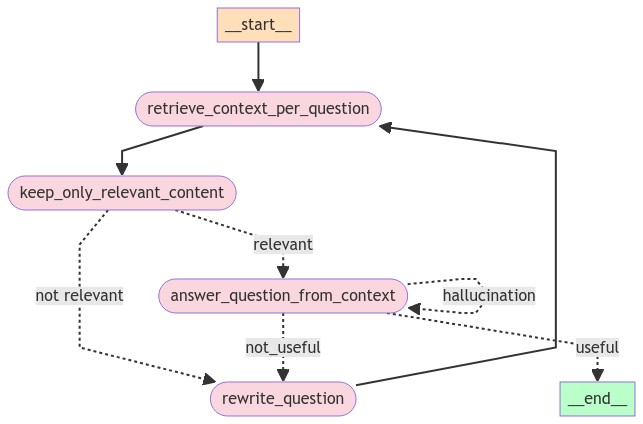

In [ ]:
# -----------------------------------------------
# Qualitative Retrieval Answer Graph Construction
# -----------------------------------------------

# Define the state for the workflow graph
class QualitativeRetievalAnswerGraphState(TypedDict):
    question: str
    context: str
    answer: str

# Create the workflow graph object
qualitative_retrieval_answer_workflow = StateGraph(QualitativeRetievalAnswerGraphState)

# -------------------------
# Define and Add Graph Nodes
# -------------------------
# Each node represents a function in the pipeline

# Node: Retrieve context for the question from vector stores
qualitative_retrieval_answer_workflow.add_node(
    "retrieve_context_per_question", retrieve_context_per_question
)

# Node: Use LLM to keep only relevant content from the retrieved context
qualitative_retrieval_answer_workflow.add_node(
    "keep_only_relevant_content", keep_only_relevant_content
)

# Node: Rewrite the question for better retrieval if needed
qualitative_retrieval_answer_workflow.add_node(
    "rewrite_question", rewrite_question
)

# Node: Answer the question from the relevant context using LLM
qualitative_retrieval_answer_workflow.add_node(
    "answer_question_from_context", answer_question_from_context
)

# -------------------------
# Build the Workflow Edges
# -------------------------

# Set the entry point of the workflow
qualitative_retrieval_answer_workflow.set_entry_point("retrieve_context_per_question")

# Edge: After retrieving context, filter to keep only relevant content
qualitative_retrieval_answer_workflow.add_edge(
    "retrieve_context_per_question", "keep_only_relevant_content"
)

# Conditional Edge: After filtering, check if content is relevant
# If relevant, answer the question; if not, rewrite the question
qualitative_retrieval_answer_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_relevant_content,
    {
        "relevant": "answer_question_from_context",
        "not relevant": "rewrite_question"
    },
)

# Edge: After rewriting the question, retrieve context again
qualitative_retrieval_answer_workflow.add_edge(
    "rewrite_question", "retrieve_context_per_question"
)

# Conditional Edge: After answering, grade the answer
# If hallucination, try answering again; if not useful, rewrite question; if useful, end
qualitative_retrieval_answer_workflow.add_conditional_edges(
    "answer_question_from_context",
    grade_generation_v_documents_and_question,
    {
        "hallucination": "answer_question_from_context",
        "not_useful": "rewrite_question",
        "useful": END
    },
)

# Compile the workflow graph into an executable app
qualitative_retrieval_answer_retrival_app = qualitative_retrieval_answer_workflow.compile()

# Display the workflow graph as a Mermaid diagram
display(
    Image(
        qualitative_retrieval_answer_retrival_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

For more complex tasks, where the question cannot be answered solely by retrieving information based on semantic similarity, we need a more sophisticated pipeline. To achieve this, we may first break down the graph into several sub-graphs that will serve as functions for the sophisticated pipeline.







### Let's add a function that Verifies that the distilled content is grounded in the original context

In [ ]:
# --- Function: Check if Distilled Content is Grounded in the Original Context ---

# Prompt template for the LLM to determine grounding
is_distilled_content_grounded_on_content_prompt_template = """
You receive some distilled content: {distilled_content} and the original context: {original_context}.
You need to determine if the distilled content is grounded on the original context.
If the distilled content is grounded on the original context, set the grounded field to true.
If the distilled content is not grounded on the original context, set the grounded field to false.
{format_instructions}
"""

# Output schema for the LLM's response
class IsDistilledContentGroundedOnContent(BaseModel):
    grounded: bool = Field(
        description="Whether the distilled content is grounded on the original context."
    )
    explanation: str = Field(
        description="An explanation of why the distilled content is or is not grounded on the original context."
    )

# JSON parser for the output schema
is_distilled_content_grounded_on_content_json_parser = JsonOutputParser(
    pydantic_object=IsDistilledContentGroundedOnContent
)

# Create the prompt object for the LLM
is_distilled_content_grounded_on_content_prompt = PromptTemplate(
    template=is_distilled_content_grounded_on_content_prompt_template,
    input_variables=["distilled_content", "original_context"],
    partial_variables={
        "format_instructions": is_distilled_content_grounded_on_content_json_parser.get_format_instructions()
    },
)

# Initialize the LLM for this task
is_distilled_content_grounded_on_content_llm = ChatGroq(
    temperature=0,
    model_name="llama3-70b-8192",
    groq_api_key=groq_api_key,
    max_tokens=4000
)

# Compose the chain: prompt -> LLM -> output parser
is_distilled_content_grounded_on_content_chain = (
    is_distilled_content_grounded_on_content_prompt
    | is_distilled_content_grounded_on_content_llm
    | is_distilled_content_grounded_on_content_json_parser
)

def is_distilled_content_grounded_on_content(state):
    """
    Determines if the distilled content is grounded on the original context.

    Args:
        state (dict): A dictionary containing:
            - "relevant_context": The distilled content.
            - "context": The original context.

    Returns:
        str: "grounded on the original context" if grounded, otherwise "not grounded on the original context".
    """
    pprint("--------------------")
    print("Determining if the distilled content is grounded on the original context...")

    distilled_content = state["relevant_context"]
    original_context = state["context"]

    input_data = {
        "distilled_content": distilled_content,
        "original_context": original_context
    }

    # Invoke the LLM chain to check grounding
    output = is_distilled_content_grounded_on_content_chain.invoke(input_data)
    grounded = output["grounded"]

    if grounded:
        print("The distilled content is grounded on the original context.")
        return "grounded on the original context"
    else:
        print("The distilled content is not grounded on the original context.")
        return "not grounded on the original context"

### Create functions for each type of retrieval

In [ ]:
# -----------------------------------------------------------
# Retrieval Functions for Different Context Types
# -----------------------------------------------------------

def retrieve_chunks_context_per_question(state):
    """
    Retrieves relevant context for a given question from the book chunks.

    Args:
        state (dict): A dictionary containing the question to answer, with key "question".

    Returns:
        dict: A dictionary with keys:
            - "context": Aggregated context string from relevant book chunks.
            - "question": The original question.
    """
    print("Retrieving relevant chunks...")
    question = state["question"]
    # Retrieve relevant book chunks using the retriever
    docs = chunks_query_retriever.get_relevant_documents(question)
    # Concatenate the content of the retrieved documents
    context = " ".join(doc.page_content for doc in docs)
    context = escape_quotes(context)
    return {"context": context, "question": question}

def retrieve_summaries_context_per_question(state):
    """
    Retrieves relevant context for a given question from chapter summaries.

    Args:
        state (dict): A dictionary containing the question to answer, with key "question".

    Returns:
        dict: A dictionary with keys:
            - "context": Aggregated context string from relevant chapter summaries.
            - "question": The original question.
    """
    print("Retrieving relevant chapter summaries...")
    question = state["question"]
    # Retrieve relevant chapter summaries using the retriever
    docs_summaries = chapter_summaries_query_retriever.get_relevant_documents(question)
    # Concatenate the content of the retrieved summaries, including chapter citation
    context_summaries = " ".join(
        f"{doc.page_content} (Chapter {doc.metadata['chapter']})" for doc in docs_summaries
    )
    context_summaries = escape_quotes(context_summaries)
    return {"context": context_summaries, "question": question}

def retrieve_book_quotes_context_per_question(state):
    """
    Retrieves relevant context for a given question from book quotes.

    Args:
        state (dict): A dictionary containing the question to answer, with key "question".

    Returns:
        dict: A dictionary with keys:
            - "context": Aggregated context string from relevant book quotes.
            - "question": The original question.
    """
    question = state["question"]
    print("Retrieving relevant book quotes...")
    # Retrieve relevant book quotes using the retriever
    docs_book_quotes = book_quotes_query_retriever.get_relevant_documents(question)
    # Concatenate the content of the retrieved quotes
    book_quotes = " ".join(doc.page_content for doc in docs_book_quotes)
    book_quotes_context = escape_quotes(book_quotes)
    return {"context": book_quotes_context, "question": question}

## Create sub graph for each type of retrieval

### The first sub-graph would be for retrieval and distillation of the relevant information with some modification

In [ ]:
class QualitativeRetrievalGraphState(TypedDict):
    """
    Represents the state of the qualitative retrieval graph.

    Attributes:
        question (str): The input question to be answered.
        context (str): The context retrieved from the source (e.g., book chunks, summaries, or quotes).
        relevant_context (str): The distilled or filtered context that is most relevant to the question.
    """
    question: str
    context: str
    relevant_context: str

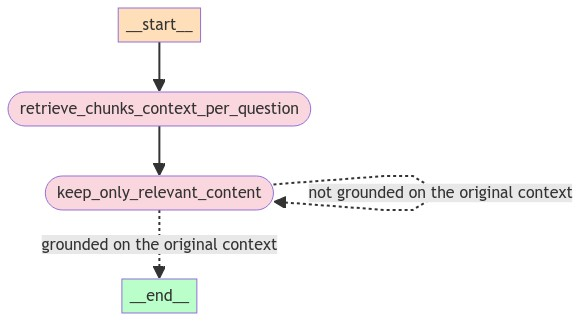

In [ ]:
# -----------------------------------------------------------
# Qualitative Chunks Retrieval Workflow Graph Construction
# -----------------------------------------------------------

# 1. Create the workflow graph object with the appropriate state type
qualitative_chunks_retrieval_workflow = StateGraph(QualitativeRetrievalGraphState)

# 2. Define and add nodes to the graph
# Node: Retrieve relevant context from book chunks for the question
qualitative_chunks_retrieval_workflow.add_node(
    "retrieve_chunks_context_per_question",
    retrieve_chunks_context_per_question
)
# Node: Use LLM to keep only the relevant content from the retrieved context
qualitative_chunks_retrieval_workflow.add_node(
    "keep_only_relevant_content",
    keep_only_relevant_content
)

# 3. Set the entry point of the workflow
qualitative_chunks_retrieval_workflow.set_entry_point("retrieve_chunks_context_per_question")

# 4. Add edges to define the workflow
# After retrieving context, filter to keep only relevant content
qualitative_chunks_retrieval_workflow.add_edge(
    "retrieve_chunks_context_per_question",
    "keep_only_relevant_content"
)

# Conditional edge: After filtering, check if distilled content is grounded in the original context
# If grounded, end; if not, repeat filtering
qualitative_chunks_retrieval_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_distilled_content_grounded_on_content,
    {
        "grounded on the original context": END,
        "not grounded on the original context": "keep_only_relevant_content"
    },
)

# 5. Compile the workflow graph into an executable app
qualitative_chunks_retrieval_workflow_app = qualitative_chunks_retrieval_workflow.compile()

# 6. Display the workflow graph as a Mermaid diagram
display(
    Image(
        qualitative_chunks_retrieval_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

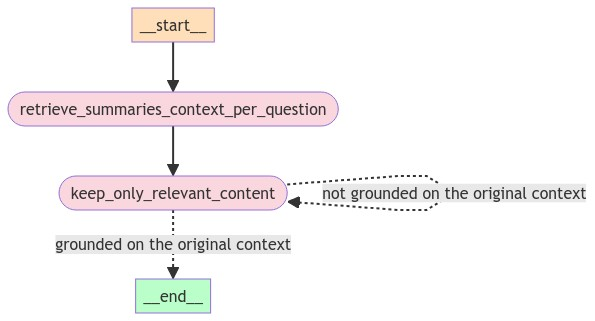

In [ ]:
# -----------------------------------------------------------
# Qualitative Summaries Retrieval Workflow Graph Construction
# -----------------------------------------------------------

# 1. Create the workflow graph object with the appropriate state type
qualitative_summaries_retrieval_workflow = StateGraph(QualitativeRetrievalGraphState)

# 2. Define and add nodes to the graph
# Node: Retrieve relevant context from chapter summaries for the question
qualitative_summaries_retrieval_workflow.add_node(
    "retrieve_summaries_context_per_question",
    retrieve_summaries_context_per_question
)
# Node: Use LLM to keep only the relevant content from the retrieved context
qualitative_summaries_retrieval_workflow.add_node(
    "keep_only_relevant_content",
    keep_only_relevant_content
)

# 3. Set the entry point of the workflow
qualitative_summaries_retrieval_workflow.set_entry_point("retrieve_summaries_context_per_question")

# 4. Add edges to define the workflow
# After retrieving context, filter to keep only relevant content
qualitative_summaries_retrieval_workflow.add_edge(
    "retrieve_summaries_context_per_question",
    "keep_only_relevant_content"
)

# Conditional edge: After filtering, check if distilled content is grounded in the original context
# If grounded, end; if not, repeat filtering
qualitative_summaries_retrieval_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_distilled_content_grounded_on_content,
    {
        "grounded on the original context": END,
        "not grounded on the original context": "keep_only_relevant_content"
    },
)

# 5. Compile the workflow graph into an executable app
qualitative_summaries_retrieval_workflow_app = qualitative_summaries_retrieval_workflow.compile()

# 6. Display the workflow graph as a Mermaid diagram
display(
    Image(
        qualitative_summaries_retrieval_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

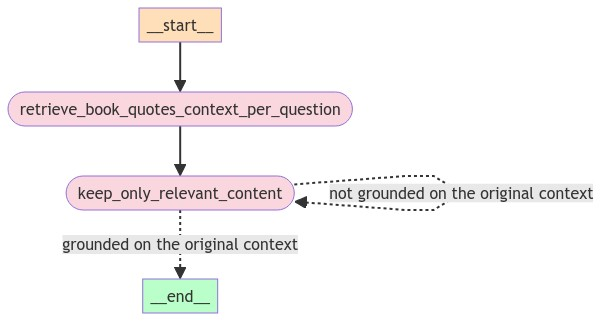

In [ ]:
# -----------------------------------------------------------
# Qualitative Book Quotes Retrieval Workflow Graph Construction
# -----------------------------------------------------------

# 1. Create the workflow graph object with the appropriate state type
qualitative_book_quotes_retrieval_workflow = StateGraph(QualitativeRetrievalGraphState)

# 2. Define and add nodes to the graph
# Node: Retrieve relevant context from book quotes for the question
qualitative_book_quotes_retrieval_workflow.add_node(
    "retrieve_book_quotes_context_per_question",
    retrieve_book_quotes_context_per_question
)
# Node: Use LLM to keep only the relevant content from the retrieved context
qualitative_book_quotes_retrieval_workflow.add_node(
    "keep_only_relevant_content",
    keep_only_relevant_content
)

# 3. Set the entry point of the workflow
qualitative_book_quotes_retrieval_workflow.set_entry_point("retrieve_book_quotes_context_per_question")

# 4. Add edges to define the workflow
# After retrieving context, filter to keep only relevant content
qualitative_book_quotes_retrieval_workflow.add_edge(
    "retrieve_book_quotes_context_per_question",
    "keep_only_relevant_content"
)

# Conditional edge: After filtering, check if distilled content is grounded in the original context
# If grounded, end; if not, repeat filtering
qualitative_book_quotes_retrieval_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_distilled_content_grounded_on_content,
    {
        "grounded on the original context": END,
        "not grounded on the original context": "keep_only_relevant_content"
    },
)

# 5. Compile the workflow graph into an executable app
qualitative_book_quotes_retrieval_workflow_app = qualitative_book_quotes_retrieval_workflow.compile()

# 6. Display the workflow graph as a Mermaid diagram
display(
    Image(
        qualitative_book_quotes_retrieval_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Test the retreive-and-keep-relevant-content graphs

In [ ]:
# -----------------------------------------------------------
# Initialize the state for the retrieval/answering pipeline
# -----------------------------------------------------------
# This dictionary defines the initial state for the workflow,
# specifying the question to be answered.
# You can modify the "question" value to test different queries.
init_state = {
    "question": "worse than getting killed"  # The question to answer
}

In [ ]:
# -----------------------------------------------------------
# Test the book chunks retrieval workflow
# -----------------------------------------------------------

# Stream the outputs from the qualitative_chunks_retrieval_workflow_app
# for the given initial state (init_state contains the question to answer).
for output in qualitative_chunks_retrieval_workflow_app.stream(init_state):
    # Iterate through the output items (node name, value)
    for _, value in output.items():
        pass  # The value variable will hold the latest state after each node execution
    pprint("--------------------")  # Print a separator for clarity between steps

# After the workflow completes, print the final relevant context extracted
print(f'relevant context: {value["relevant_context"]}')

In [ ]:
# -----------------------------------------------------------
# Test the chapter summaries retrieval workflow
# -----------------------------------------------------------

# Stream the outputs from the qualitative_summaries_retrieval_workflow_app
# for the given initial state (init_state contains the question to answer).
for output in qualitative_summaries_retrieval_workflow_app.stream(init_state):
    # Iterate through the output items (node name, value)
    for _, value in output.items():
        pass  # The value variable will hold the latest state after each node execution
    pprint("--------------------")  # Print a separator for clarity between steps

# After the workflow completes, print the final relevant context extracted
print(f'relevant context: {value["relevant_context"]}')

In [ ]:
# -----------------------------------------------------------
# Test the book quotes retrieval workflow
# -----------------------------------------------------------

# Stream the outputs from the qualitative_book_quotes_retrieval_workflow_app
# for the given initial state (init_state contains the question to answer).
for output in qualitative_book_quotes_retrieval_workflow_app.stream(init_state):
    # Iterate through the output items (node name, value)
    for _, value in output.items():
        pass  # The value variable will hold the latest state after each node execution
    pprint("--------------------")  # Print a separator for clarity between steps

# After the workflow completes, print the final relevant context extracted
print(f'relevant context: {value["relevant_context"]}')

### Add a shorter version of the answer verification, checking only if grounded on context

In [ ]:
def is_answer_grounded_on_context(state):
    """
    Determines if the answer to the question is grounded in the provided context (i.e., not a hallucination).

    Args:
        state (dict): A dictionary containing:
            - "context": The context used to answer the question.
            - "answer": The generated answer to the question.

    Returns:
        str: "hallucination" if the answer is not grounded in the context, 
             "grounded on context" if the answer is supported by the context.
    """
    print("Checking if the answer is grounded in the facts...")

    # Extract context and answer from the state
    context = state["context"]
    answer = state["answer"]

    # Use the LLM chain to check if the answer is grounded in the context
    result = is_grounded_on_facts_chain.invoke({"context": context, "answer": answer})
    grounded_on_facts = result.grounded_on_facts

    # Return the result based on grounding
    if not grounded_on_facts:
        print("The answer is hallucination.")
        return "hallucination"
    else:
        print("The answer is grounded in the facts.")
        return "grounded on context"

### The last sub-graph will be a component that answers a question given context, without hallucinations

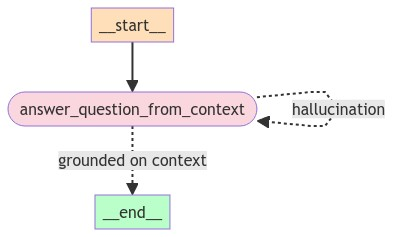

In [ ]:
# -----------------------------------------------
# Qualitative Answer Workflow Graph Construction
# -----------------------------------------------

# Define the state for the answer workflow graph
class QualitativeAnswerGraphState(TypedDict):
    """
    Represents the state of the qualitative answer graph.

    Attributes:
        question (str): The input question to be answered.
        context (str): The context used to answer the question.
        answer (str): The generated answer to the question.
    """
    question: str
    context: str
    answer: str

# Create the workflow graph object
qualitative_answer_workflow = StateGraph(QualitativeAnswerGraphState)

# -------------------------
# Define and Add Graph Nodes
# -------------------------

# Node: Answer the question from the provided context using LLM
qualitative_answer_workflow.add_node(
    "answer_question_from_context",
    answer_question_from_context
)

# -------------------------
# Build the Workflow Edges
# -------------------------

# Set the entry point of the workflow
qualitative_answer_workflow.set_entry_point("answer_question_from_context")

# Conditional Edge: After answering, check if the answer is grounded in the context
# If hallucination, try answering again; if grounded, end
qualitative_answer_workflow.add_conditional_edges(
    "answer_question_from_context",
    is_answer_grounded_on_context,
    {
        "hallucination": "answer_question_from_context",
        "grounded on context": END
    }
)

# Compile the workflow graph into an executable app
qualitative_answer_workflow_app = qualitative_answer_workflow.compile()

# Display the workflow graph as a Mermaid diagram
display(
    Image(
        qualitative_answer_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Test the answer-from-question-graph

In [ ]:
# -----------------------------------------------
# Test the qualitative answer workflow graph
# -----------------------------------------------

# Define the question and context for the test
question = "who is harry?"  # The question to answer
context = "Harry Potter is a cat."  # The context to answer the question from

# Initialize the state for the workflow
init_state = {
    "question": question,
    "context": context
}

# Stream the outputs from the qualitative_answer_workflow_app
# This will execute each node in the workflow step by step
for output in qualitative_answer_workflow_app.stream(init_state):
    # Iterate through the output items (node name, value)
    for _, value in output.items():
        pass  # The value variable holds the latest state after each node execution
    pprint("--------------------")  # Print a separator for clarity between steps

# After the workflow completes, print the final answer generated by the workflow
print(f'answer: {value["answer"]}')

Answering the question from the retrieved context...
answer before checking hallucination: The context states that Harry Potter is a cat. Therefore, Harry is a cat.
Checking if the answer is grounded in the facts...
The answer is grounded in the facts.
'--------------------'
answer: The context states that Harry Potter is a cat. Therefore, Harry is a cat.


# Now let's define the sophisticated pipeline components

### The state of each step of the graph should be in this structure:

In [2]:
from typing import TypedDict, List, Dict

class PlanExecute(TypedDict):
    """
    Represents the state at each step of the plan execution pipeline.

    Attributes:
        curr_state (str): The current state or status of the execution.
        question (str): The original user question.
        anonymized_question (str): The anonymized version of the question (entities replaced with variables).
        query_to_retrieve_or_answer (str): The query to be used for retrieval or answering.
        plan (List[str]): The current plan as a list of steps to execute.
        past_steps (List[str]): List of steps that have already been executed.
        mapping (dict): Mapping of anonymized variables to original named entities.
        curr_context (str): The current context used for answering or retrieval.
        aggregated_context (str): The accumulated context from previous steps.
        tool (str): The tool or method used for the current step (e.g., retrieval, answer).
        response (str): The response or output generated at this step.
    """
    curr_state: str
    question: str
    anonymized_question: str
    query_to_retrieve_or_answer: str
    plan: List[str]
    past_steps: List[str]
    mapping: Dict[str, str]
    curr_context: str
    aggregated_context: str
    tool: str
    response: str

### Define the Plan node - constructs a plan composed of steps, of how to tackle a question

In [ ]:
from typing import List
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# -----------------------------------------------
# Planning Component for Multi-Step Question Answering
# -----------------------------------------------


# Define the output schema for the plan
class Plan(BaseModel):
    """
    Represents a step-by-step plan to answer a given question.
    Attributes:
        steps (List[str]): Ordered list of steps to follow.
    """
    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

# Prompt template for generating a plan from a question
planner_prompt = """
For the given query {question}, come up with a simple step by step plan of how to figure out the answer. 

This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. 
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
"""

planner_prompt = PromptTemplate(
    template=planner_prompt,
    input_variables=["question"],
)

# Initialize the LLM for planning (using GPT-4o)
planner_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o",
    max_tokens=2000
)

# Compose the planning chain: prompt -> LLM -> structured output
planner = planner_prompt | planner_llm.with_structured_output(Plan)

### A function to break down each task to either retrieve or answer

In [ ]:
# -----------------------------------------------------------
# Chain to Refine a Plan into Executable Steps for Retrieval/Answering
# -----------------------------------------------------------

# Prompt template for refining a plan so that each step is executable by a retrieval or answer operation
break_down_plan_prompt_template = """
You receive a plan {plan} which contains a series of steps to follow in order to answer a query. 
You need to go through the plan and refine it according to these rules:
1. Every step must be executable by one of the following:
    i. Retrieving relevant information from a vector store of book chunks
    ii. Retrieving relevant information from a vector store of chapter summaries
    iii. Retrieving relevant information from a vector store of book quotes
    iv. Answering a question from a given context.
2. Every step should contain all the information needed to execute it.

Output the refined plan.
"""

# Create a PromptTemplate for the LLM
break_down_plan_prompt = PromptTemplate(
    template=break_down_plan_prompt_template,
    input_variables=["plan"],
)

# Initialize the LLM for plan breakdown (using GPT-4o)
break_down_plan_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o",
    max_tokens=2000
)

# Compose the chain: prompt -> LLM -> structured output (Plan)
break_down_plan_chain = break_down_plan_prompt | break_down_plan_llm.with_structured_output(Plan)

### Example of how to use the planner


In [ ]:
# -----------------------------------------------------------
# Example: How to Use the Planner and Refine the Plan
# -----------------------------------------------------------

# 1. Define the question to answer
question = {"question": "how did the main character beat the villain?"}

# 2. Generate a step-by-step plan to answer the question using the planner chain
my_plan = planner.invoke(question)
print("Initial Plan:")
print(my_plan)

# 3. Refine the plan so that each step is executable by a retrieval or answer operation
refined_plan = break_down_plan_chain.invoke(my_plan.steps)
print("\nRefined Plan:")
print(refined_plan)

steps=['Identify the main character and the villain in the story.', 'Locate the climax or the final confrontation between the main character and the villain.', 'Analyze the actions taken by the main character during this confrontation.', 'Determine the specific action or strategy that led to the defeat of the villain.', 'Summarize the findings to answer how the main character beat the villain.']
steps=['Identify the main character and the villain in the story by retrieving relevant information from a vector store of book chunks, chapter summaries, or book quotes.', 'Locate the climax or the final confrontation between the main character and the villain by retrieving relevant information from a vector store of book chunks, chapter summaries, or book quotes.', 'Analyze the actions taken by the main character during this confrontation by retrieving relevant information from a vector store of book chunks, chapter summaries, or book quotes.', 'Determine the specific action or strategy that 

### Given the original question, the current plan, the past steps, and the so far aggregated information, update the plan

In [ ]:
# -----------------------------------------------------------
# Replanner: Update Plan Based on Progress and Aggregated Context
# -----------------------------------------------------------

# Define a Pydantic model for the possible results of the replanning action
class ActPossibleResults(BaseModel):
    """
    Represents the possible results of the replanning action.

    Attributes:
        plan (Plan): The updated plan to follow in the future.
        explanation (str): Explanation of the action taken or the reasoning behind the plan update.
    """
    plan: Plan = Field(description="Plan to follow in future.")
    explanation: str = Field(description="Explanation of the action.")

# Create a JSON output parser for the ActPossibleResults schema
act_possible_results_parser = JsonOutputParser(pydantic_object=ActPossibleResults)

# Prompt template for replanning, instructing the LLM to update the plan based on the current state
replanner_prompt_template = """
For the given objective, come up with a simple step by step plan of how to figure out the answer. 
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. 
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Assume that the answer was not found yet and you need to update the plan accordingly, so the plan should never be empty.

Your objective was this:
{question}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

You already have the following context:
{aggregated_context}

Update your plan accordingly. If further steps are needed, fill out the plan with only those steps.
Do not return previously done steps as part of the plan.

The format is JSON so escape quotes and new lines.

{format_instructions}
"""

# Create a PromptTemplate object for the replanner
replanner_prompt = PromptTemplate(
    template=replanner_prompt_template,
    input_variables=["question", "plan", "past_steps", "aggregated_context"],
    partial_variables={"format_instructions": act_possible_results_parser.get_format_instructions()},
)

# Initialize the LLM for replanning (using GPT-4o)
replanner_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o",
    max_tokens=2000
)

# Compose the replanner chain: prompt -> LLM -> output parser
replanner = replanner_prompt | replanner_llm | act_possible_results_parser

### Define the task handler - decides whether to use the first sub-graph or the second sub-graph to handle each task from the plan

In [ ]:
# -----------------------------------------------------------
# Task Handler: Decide Which Tool to Use for Each Task
# -----------------------------------------------------------

# Prompt template for the task handler LLM
tasks_handler_prompt_template = """
You are a task handler that receives a task {curr_task} and have to decide with tool to use to execute the task.
You have the following tools at your disposal:
Tool A: a tool that retrieves relevant information from a vector store of book chunks based on a given query.
- use Tool A when you think the current task should search for information in the book chunks.
Tool B: a tool that retrieves relevant information from a vector store of chapter summaries based on a given query.
- use Tool B when you think the current task should search for information in the chapter summaries.
Tool C: a tool that retrieves relevant information from a vector store of quotes from the book based on a given query.
- use Tool C when you think the current task should search for information in the book quotes.
Tool D: a tool that answers a question from a given context.
- use Tool D ONLY when you the current task can be answered by the aggregated context {aggregated_context}

You also receive the last tool used {last_tool}
if {last_tool} was retrieve_chunks, use other tools than Tool A.

You also have the past steps {past_steps} that you can use to make decisions and understand the context of the task.
You also have the initial user's question {question} that you can use to make decisions and understand the context of the task.
if you decide to use Tools A,B or C, output the query to be used for the tool and also output the relevant tool.
if you decide to use Tool D, output the question to be used for the tool, the context, and also that the tool to be used is Tool D.
"""

# Output schema for the task handler
class TaskHandlerOutput(BaseModel):
    """
    Output schema for the task handler.
    - query: The query to be either retrieved from the vector store, or the question that should be answered from context.
    - curr_context: The context to be based on in order to answer the query.
    - tool: The tool to be used; should be one of 'retrieve_chunks', 'retrieve_summaries', 'retrieve_quotes', or 'answer_from_context'.
    """
    query: str = Field(description="The query to be either retrieved from the vector store, or the question that should be answered from context.")
    curr_context: str = Field(description="The context to be based on in order to answer the query.")
    tool: str = Field(description="The tool to be used should be either retrieve_chunks, retrieve_summaries, retrieve_quotes, or answer_from_context.")

# Create the prompt object for the task handler
task_handler_prompt = PromptTemplate(
    template=tasks_handler_prompt_template,
    input_variables=["curr_task", "aggregated_context", "last_tool", "past_steps", "question"],
)

# Initialize the LLM for the task handler (using GPT-4o)
task_handler_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o",
    max_tokens=2000
)

# Compose the task handler chain: prompt -> LLM -> structured output
task_handler_chain = task_handler_prompt | task_handler_llm.with_structured_output(TaskHandlerOutput)

### In order to generate a general plan, without any biases based on prior knowledge of any LLM, we anonymize the input question, first, and map the name entities into variables

In [ ]:
# -----------------------------------------------------------
# Anonymize Question Chain: Replace Named Entities with Variables
# -----------------------------------------------------------

# Define a Pydantic model for the anonymized question output
class AnonymizeQuestion(BaseModel):
  """
  Output schema for the anonymized question.
  Attributes:
    anonymized_question (str): The question with named entities replaced by variables.
    mapping (dict): Mapping of variables to original named entities.
    explanation (str): Explanation of the anonymization process.
  """
  anonymized_question: str = Field(description="Anonymized question.")
  mapping: dict = Field(description="Mapping of original name entities to variables.")
  explanation: str = Field(description="Explanation of the action.")

# Create a JSON output parser for the AnonymizeQuestion schema
anonymize_question_parser = JsonOutputParser(pydantic_object=AnonymizeQuestion)

# Prompt template for the LLM to anonymize questions
anonymize_question_prompt_template = """
You are a question anonymizer. The input you receive is a string containing several words that
construct a question {question}. Your goal is to change all name entities in the input to variables, and remember the mapping of the original name entities to the variables.
Example 1:
  if the input is "who is harry potter?" the output should be "who is X?" and the mapping should be {{"X": "harry potter"}}
Example 2:
  if the input is "how did the bad guy played with the alex and rony?"
  the output should be "how did the X played with the Y and Z?" and the mapping should be {{"X": "bad guy", "Y": "alex", "Z": "rony"}}
You must replace all name entities in the input with variables, and remember the mapping of the original name entities to the variables.
Output the anonymized question and the mapping in a JSON format.
{format_instructions}
"""

# Create the PromptTemplate object for the anonymization task
anonymize_question_prompt = PromptTemplate(
  template=anonymize_question_prompt_template,
  input_variables=["question"],
  partial_variables={"format_instructions": anonymize_question_parser.get_format_instructions()},
)

# Initialize the LLM for anonymization (using GPT-4o)
anonymize_question_llm = ChatOpenAI(
  temperature=0,
  model_name="gpt-4o",
  max_tokens=2000
)

# Compose the anonymization chain: prompt -> LLM -> output parser
anonymize_question_chain = (
  anonymize_question_prompt
  | anonymize_question_llm
  | anonymize_question_parser
)

### After the plan is constructed based on the anonymized question, we de-anonymize the plan, using the mapped variables

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

# -----------------------------------------------------------
# De-Anonymize Plan Chain: Replace Variables in Plan with Mapped Words
# -----------------------------------------------------------


class DeAnonymizePlan(BaseModel):
    """
    Output schema for the de-anonymized plan.
    Attributes:
        plan (List): Plan to follow in future, with all variables replaced by the mapped words.
    """
    plan: List = Field(
        description="Plan to follow in future. with all the variables replaced with the mapped words."
    )

# Prompt template for de-anonymizing a plan
de_anonymize_plan_prompt_template = (
    "You receive a list of tasks: {plan}, where some of the words are replaced with mapped variables. "
    "You also receive the mapping for those variables to words {mapping}. "
    "Replace all the variables in the list of tasks with the mapped words. "
    "If no variables are present, return the original list of tasks. "
    "In any case, just output the updated list of tasks in a JSON format as described here, "
    "without any additional text apart from the JSON."
)

# Create the PromptTemplate object for the de-anonymization task
de_anonymize_plan_prompt = PromptTemplate(
    template=de_anonymize_plan_prompt_template,
    input_variables=["plan", "mapping"],
)

# Initialize the LLM for de-anonymization (using GPT-4o)
de_anonymize_plan_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o",
    max_tokens=2000
)

# Compose the de-anonymization chain: prompt -> LLM -> structured output
de_anonymize_plan_chain = (
    de_anonymize_plan_prompt
    | de_anonymize_plan_llm.with_structured_output(DeAnonymizePlan)
)

### Example of how to build a plan


In [ ]:
# -----------------------------------------------------------
# Example: Anonymize, Plan, and De-anonymize a Question
# -----------------------------------------------------------

# 1. Define the question to answer
state1 = {
    'question': "how did the harry beat quirrell? \n"
}
print(f'question: {state1["question"]}')

# 2. Anonymize the question (replace named entities with variables)
anonymized_question_output = anonymize_question_chain.invoke(state1)
anonymized_question = anonymized_question_output["anonymized_question"]  # The anonymized question
mapping = anonymized_question_output["mapping"]  # Mapping of variables to original entities

print(f'anonymized_query: {anonymized_question} \n')
print(f'mapping: {mapping} \n')

# 3. Generate a step-by-step plan for the anonymized question
plan = planner.invoke({"question": anonymized_question})
print(text_wrap(f'plan: {plan.steps}'))
print("")

# 4. De-anonymize the plan (replace variables back with original entities)
deanonymized_plan = de_anonymize_plan_chain.invoke({
    "plan": plan.steps,
    "mapping": mapping
})
print(text_wrap(f'deanonymized_plan: {deanonymized_plan.plan}'))

question: how did the harry beat quirrell? 

anonimized_querry: how did the X beat Y? 

mapping: {'X': 'harry', 'Y': 'quirrell'} 

plan: ['Identify the context or domain of the query (e.g., sports, competition, game, etc.).', 'Gather information about
the event or competition where X and Y participated.', 'Find the specific instance or match where X competed against
Y.', 'Look up the results of that specific instance or match.', 'Analyze the details of the match to understand how X
managed to beat Y.', 'Summarize the key points that explain how X beat Y.']

deanonimized_plan: ['Identify the context or domain of the query (e.g., sports, competition, game, etc.).', 'Gather
information about the event or competition where harry and quirrell participated.', 'Find the specific instance or match
where harry competed against quirrell.', 'Look up the results of that specific instance or match.', 'Analyze the details
of the match to understand how harry managed to beat quirrell.', 'Summarize th

### A function that checks if the final answer can be deduced already, based on the aggregated information

In [ ]:
# -----------------------------------------------------------
# LLM Chain: Check if a Question Can Be Fully Answered from Context
# -----------------------------------------------------------

# Define the output schema for the LLM's response
class CanBeAnsweredAlready(BaseModel):
    """
    Output schema for checking if the question can be fully answered from the given context.
    Attributes:
        can_be_answered (bool): Whether the question can be fully answered or not based on the given context.
    """
    can_be_answered: bool = Field(
        description="Whether the question can be fully answered or not based on the given context."
    )

# Prompt template for the LLM to determine answerability
can_be_answered_already_prompt_template = """
You receive a query: {question} and a context: {context}.
You need to determine if the question can be fully answered relying only on the given context.
The only information you have and can rely on is the context you received. 
You have no prior knowledge of the question or the context.
If you think the question can be answered based on the context, output 'true', otherwise output 'false'.
"""

# Create the PromptTemplate object
can_be_answered_already_prompt = PromptTemplate(
    template=can_be_answered_already_prompt_template,
    input_variables=["question", "context"],
)

# Initialize the LLM for this task (using GPT-4o)
can_be_answered_already_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o",
    max_tokens=2000
)

# Compose the chain: prompt -> LLM -> structured output
can_be_answered_already_chain = (
    can_be_answered_already_prompt
    | can_be_answered_already_llm.with_structured_output(CanBeAnsweredAlready)
)

### Define the sophisticated pipeline graph functions

In [4]:
from pprint import pprint

def run_task_handler_chain(state: PlanExecute):
    """
    Run the task handler chain to decide which tool to use to execute the task.

    Args:
        state: The current state of the plan execution.

    Returns:
        The updated state of the plan execution.
    """
    state["curr_state"] = "task_handler"
    print("the current plan is:")
    print(state["plan"])
    pprint("--------------------") 

    # Initialize past_steps if not present
    if not state['past_steps']:
        state["past_steps"] = []

    # Get the current task from the plan
    curr_task = state["plan"][0]

    # Prepare inputs for the task handler chain
    inputs = {
        "curr_task": curr_task,
        "aggregated_context": state["aggregated_context"],
        "last_tool": state["tool"],
        "past_steps": state["past_steps"],
        "question": state["question"]
    }
    
    # Invoke the task handler chain
    output = task_handler_chain.invoke(inputs)
  
    # Update state with the completed task
    state["past_steps"].append(curr_task)
    state["plan"].pop(0)

    # Decide which tool to use based on output
    if output.tool == "retrieve_chunks":
        state["query_to_retrieve_or_answer"] = output.query
        state["tool"] = "retrieve_chunks"
    elif output.tool == "retrieve_summaries":
        state["query_to_retrieve_or_answer"] = output.query
        state["tool"] = "retrieve_summaries"
    elif output.tool == "retrieve_quotes":
        state["query_to_retrieve_or_answer"] = output.query
        state["tool"] = "retrieve_quotes"
    elif output.tool == "answer_from_context":
        state["query_to_retrieve_or_answer"] = output.query
        state["curr_context"] = output.curr_context
        state["tool"] = "answer"
    else:
        raise ValueError("Invalid tool was outputed. Must be either 'retrieve' or 'answer_from_context'")
    return state  


def retrieve_or_answer(state: PlanExecute):
    """
    Decide whether to retrieve or answer the question based on the current state.

    Args:
        state: The current state of the plan execution.

    Returns:
        String indicating the chosen tool.
    """
    state["curr_state"] = "decide_tool"
    print("deciding whether to retrieve or answer")
    if state["tool"] == "retrieve_chunks":
        return "chosen_tool_is_retrieve_chunks"
    elif state["tool"] == "retrieve_summaries":
        return "chosen_tool_is_retrieve_summaries"
    elif state["tool"] == "retrieve_quotes":
        return "chosen_tool_is_retrieve_quotes"
    elif state["tool"] == "answer":
        return "chosen_tool_is_answer"
    else:
        raise ValueError("Invalid tool was outputed. Must be either 'retrieve' or 'answer_from_context'")  


def run_qualitative_chunks_retrieval_workflow(state):
    """
    Run the qualitative chunks retrieval workflow.

    Args:
        state: The current state of the plan execution.

    Returns:
        The state with the updated aggregated context.
    """
    state["curr_state"] = "retrieve_chunks"
    print("Running the qualitative chunks retrieval workflow...")
    question = state["query_to_retrieve_or_answer"]
    inputs = {"question": question}
    # Stream outputs from the workflow app
    for output in qualitative_chunks_retrieval_workflow_app.stream(inputs):
        for _, _ in output.items():
            pass 
        pprint("--------------------")
    # Aggregate the retrieved context
    if not state["aggregated_context"]:
        state["aggregated_context"] = ""
    state["aggregated_context"] += output['relevant_context']
    return state


def run_qualitative_summaries_retrieval_workflow(state):
    """
    Run the qualitative summaries retrieval workflow.

    Args:
        state: The current state of the plan execution.

    Returns:
        The state with the updated aggregated context.
    """
    state["curr_state"] = "retrieve_summaries"
    print("Running the qualitative summaries retrieval workflow...")
    question = state["query_to_retrieve_or_answer"]
    inputs = {"question": question}
    for output in qualitative_summaries_retrieval_workflow_app.stream(inputs):
        for _, _ in output.items():
            pass 
        pprint("--------------------")
    if not state["aggregated_context"]:
        state["aggregated_context"] = ""
    state["aggregated_context"] += output['relevant_context']
    return state


def run_qualitative_book_quotes_retrieval_workflow(state):
    """
    Run the qualitative book quotes retrieval workflow.

    Args:
        state: The current state of the plan execution.

    Returns:
        The state with the updated aggregated context.
    """
    state["curr_state"] = "retrieve_book_quotes"
    print("Running the qualitative book quotes retrieval workflow...")
    question = state["query_to_retrieve_or_answer"]
    inputs = {"question": question}
    for output in qualitative_book_quotes_retrieval_workflow_app.stream(inputs):
        for _, _ in output.items():
            pass 
        pprint("--------------------")
    if not state["aggregated_context"]:
        state["aggregated_context"] = ""
    state["aggregated_context"] += output['relevant_context']
    return state
   

def run_qualtative_answer_workflow(state):
    """
    Run the qualitative answer workflow.

    Args:
        state: The current state of the plan execution.

    Returns:
        The state with the updated aggregated context.
    """
    state["curr_state"] = "answer"
    print("Running the qualitative answer workflow...")
    question = state["query_to_retrieve_or_answer"]
    context = state["curr_context"]
    inputs = {"question": question, "context": context}
    for output in qualitative_answer_workflow_app.stream(inputs):
        for _, _ in output.items():
            pass 
        pprint("--------------------")
    if not state["aggregated_context"]:
        state["aggregated_context"] = ""
    state["aggregated_context"] += output["answer"]
    return state


def run_qualtative_answer_workflow_for_final_answer(state):
    """
    Run the qualitative answer workflow for the final answer.

    Args:
        state: The current state of the plan execution.

    Returns:
        The state with the updated response.
    """
    state["curr_state"] = "get_final_answer"
    print("Running the qualitative answer workflow for final answer...")
    question = state["question"]
    context = state["aggregated_context"]
    inputs = {"question": question, "context": context}
    for output in qualitative_answer_workflow_app.stream(inputs):
        for _, value in output.items():
            pass  
        pprint("--------------------")
    state["response"] = value
    return state


def anonymize_queries(state: PlanExecute):
    """
    Anonymizes the question.

    Args:
        state: The current state of the plan execution.

    Returns:
        The updated state with the anonymized question and mapping.
    """
    state["curr_state"] = "anonymize_question"
    print("Anonymizing question")
    pprint("--------------------")
    anonymized_question_output = anonymize_question_chain.invoke(state['question'])
    anonymized_question = anonymized_question_output["anonymized_question"]
    print(f'anonimized_querry: {anonymized_question}')
    pprint("--------------------")
    mapping = anonymized_question_output["mapping"]
    state["anonymized_question"] = anonymized_question
    state["mapping"] = mapping
    return state


def deanonymize_queries(state: PlanExecute):
    """
    De-anonymizes the plan.

    Args:
        state: The current state of the plan execution.

    Returns:
        The updated state with the de-anonymized plan.
    """
    state["curr_state"] = "de_anonymize_plan"
    print("De-anonymizing plan")
    pprint("--------------------")
    deanonimzed_plan = de_anonymize_plan_chain.invoke({"plan": state["plan"], "mapping": state["mapping"]})
    state["plan"] = deanonimzed_plan.plan
    print(f'de-anonimized_plan: {deanonimzed_plan.plan}')
    return state


def plan_step(state: PlanExecute):
    """
    Plans the next step.

    Args:
        state: The current state of the plan execution.

    Returns:
        The updated state with the plan.
    """
    state["curr_state"] = "planner"
    print("Planning step")
    pprint("--------------------")
    plan = planner.invoke({"question": state['anonymized_question']})
    state["plan"] = plan.steps
    print(f'plan: {state["plan"]}')
    return state


def break_down_plan_step(state: PlanExecute):
    """
    Breaks down the plan steps into retrievable or answerable tasks.

    Args:
        state: The current state of the plan execution.

    Returns:
        The updated state with the refined plan.
    """
    state["curr_state"] = "break_down_plan"
    print("Breaking down plan steps into retrievable or answerable tasks")
    pprint("--------------------")
    refined_plan = break_down_plan_chain.invoke(state["plan"])
    state["plan"] = refined_plan.steps
    return state


def replan_step(state: PlanExecute):
    """
    Replans the next step.

    Args:
        state: The current state of the plan execution.

    Returns:
        The updated state with the plan.
    """
    state["curr_state"] = "replan"
    print("Replanning step")
    pprint("--------------------")
    inputs = {
        "question": state["question"],
        "plan": state["plan"],
        "past_steps": state["past_steps"],
        "aggregated_context": state["aggregated_context"]
    }
    output = replanner.invoke(inputs)
    state["plan"] = output['plan']['steps']
    return state


def can_be_answered(state: PlanExecute):
    """
    Determines if the question can be answered.

    Args:
        state: The current state of the plan execution.

    Returns:
        String indicating whether the original question can be answered or not.
    """
    state["curr_state"] = "can_be_answered_already"
    print("Checking if the ORIGINAL QUESTION can be answered already")
    pprint("--------------------")
    question = state["question"]
    context = state["aggregated_context"]
    inputs = {"question": question, "context": context}
    output = can_be_answered_already_chain.invoke(inputs)
    if output.can_be_answered == True:
        print("The ORIGINAL QUESTION can be fully answered already.")
        pprint("--------------------")
        print("the aggregated context is:")
        print(text_wrap(state["aggregated_context"]))
        print("--------------------")
        return "can_be_answered_already"
    else:
        print("The ORIGINAL QUESTION cannot be fully answered yet.")
        pprint("--------------------")
        return "cannot_be_answered_yet"

### Define the sophisticated graph structure

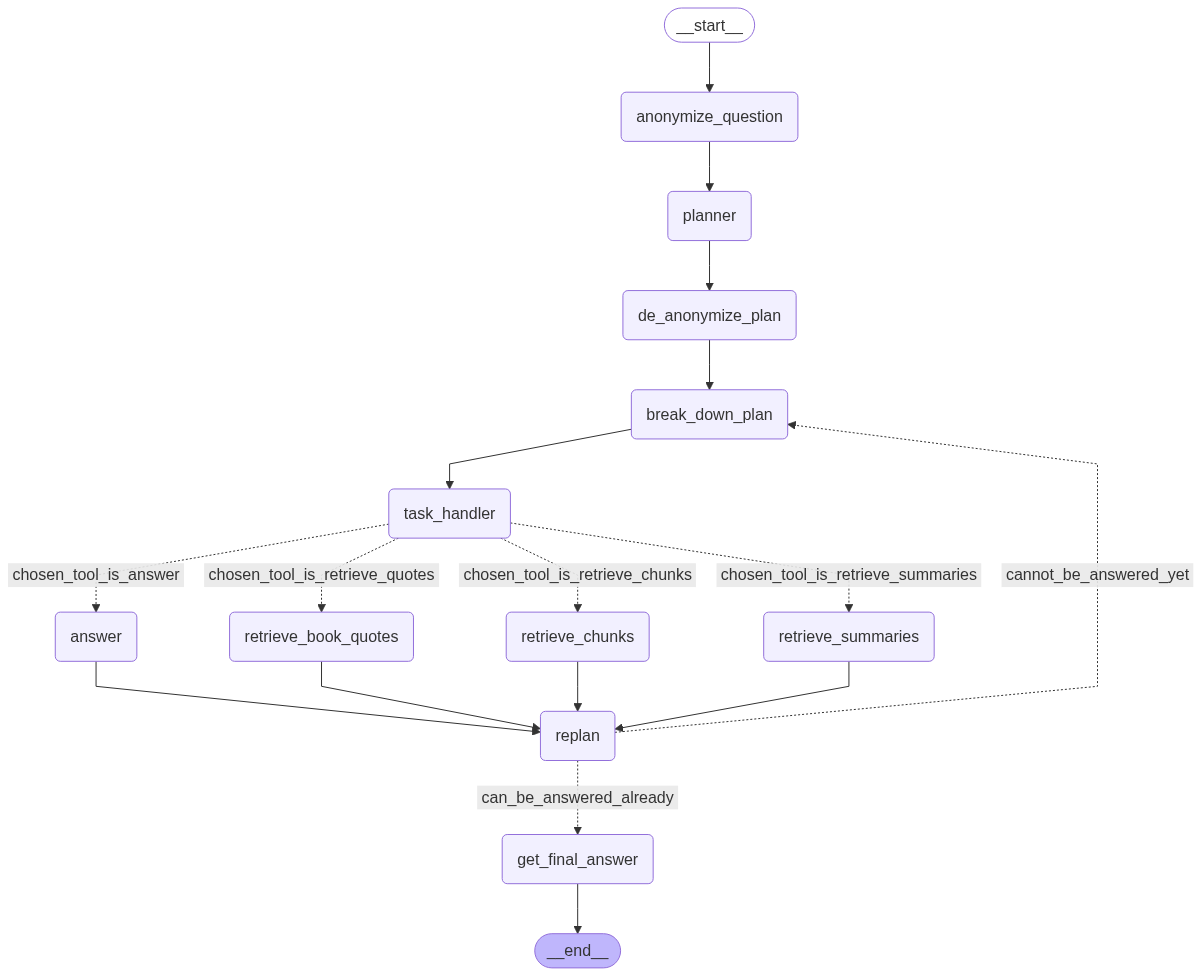

In [7]:
from langgraph.graph import StateGraph

# -----------------------------------------------------------
# Define the Plan-and-Execute Agent Workflow Graph
# -----------------------------------------------------------

# Initialize the workflow graph with the PlanExecute state
agent_workflow = StateGraph(PlanExecute)

# -------------------------
# Add Nodes (Steps/Functions)
# -------------------------

# 1. Anonymize the question (replace named entities with variables)
agent_workflow.add_node("anonymize_question", anonymize_queries)

# 2. Generate a step-by-step plan for the anonymized question
agent_workflow.add_node("planner", plan_step)

# 3. De-anonymize the plan (replace variables back with original entities)
agent_workflow.add_node("de_anonymize_plan", deanonymize_queries)

# 4. Break down the plan into retrievable/answerable tasks
agent_workflow.add_node("break_down_plan", break_down_plan_step)

# 5. Decide which tool to use for the current task
agent_workflow.add_node("task_handler", run_task_handler_chain)

# 6. Retrieve relevant book chunks
agent_workflow.add_node("retrieve_chunks", run_qualitative_chunks_retrieval_workflow)

# 7. Retrieve relevant chapter summaries
agent_workflow.add_node("retrieve_summaries", run_qualitative_summaries_retrieval_workflow)

# 8. Retrieve relevant book quotes
agent_workflow.add_node("retrieve_book_quotes", run_qualitative_book_quotes_retrieval_workflow)

# 9. Answer the question from the aggregated context
agent_workflow.add_node("answer", run_qualtative_answer_workflow)

# 10. Replan if needed (update plan based on progress/context)
agent_workflow.add_node("replan", replan_step)

# 11. Get the final answer from the aggregated context
agent_workflow.add_node("get_final_answer", run_qualtative_answer_workflow_for_final_answer)

# -------------------------
# Define Workflow Edges (Transitions)
# -------------------------

# Set the entry point of the workflow
agent_workflow.set_entry_point("anonymize_question")

# Anonymize -> Plan
agent_workflow.add_edge("anonymize_question", "planner")

# Plan -> De-anonymize
agent_workflow.add_edge("planner", "de_anonymize_plan")

# De-anonymize -> Break down plan
agent_workflow.add_edge("de_anonymize_plan", "break_down_plan")

# Break down plan -> Task handler
agent_workflow.add_edge("break_down_plan", "task_handler")

# Task handler -> (conditional) Retrieve or Answer
agent_workflow.add_conditional_edges(
    "task_handler",
    retrieve_or_answer,
    {
        "chosen_tool_is_retrieve_chunks": "retrieve_chunks",
        "chosen_tool_is_retrieve_summaries": "retrieve_summaries",
        "chosen_tool_is_retrieve_quotes": "retrieve_book_quotes",
        "chosen_tool_is_answer": "answer"
    }
)

# Retrieval/Answer nodes -> Replan
agent_workflow.add_edge("retrieve_chunks", "replan")
agent_workflow.add_edge("retrieve_summaries", "replan")
agent_workflow.add_edge("retrieve_book_quotes", "replan")
agent_workflow.add_edge("answer", "replan")

# Replan -> (conditional) Get final answer or continue
agent_workflow.add_conditional_edges(
    "replan",
    can_be_answered,
    {
        "can_be_answered_already": "get_final_answer",
        "cannot_be_answered_yet": "break_down_plan"
    }
)

# Get final answer -> End
agent_workflow.add_edge("get_final_answer", END)

# -------------------------
# Compile and Visualize the Workflow
# -------------------------

plan_and_execute_app = agent_workflow.compile()

# Display the workflow graph as a Mermaid diagram
display(Image(plan_and_execute_app.get_graph(xray=True).draw_mermaid_png()))

In [8]:
print(plan_and_execute_app.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	anonymize_question(anonymize_question)
	planner(planner)
	de_anonymize_plan(de_anonymize_plan)
	break_down_plan(break_down_plan)
	task_handler(task_handler)
	retrieve_chunks(retrieve_chunks)
	retrieve_summaries(retrieve_summaries)
	retrieve_book_quotes(retrieve_book_quotes)
	answer(answer)
	replan(replan)
	get_final_answer(get_final_answer)
	__end__([<p>__end__</p>]):::last
	__start__ --> anonymize_question;
	anonymize_question --> planner;
	answer --> replan;
	break_down_plan --> task_handler;
	de_anonymize_plan --> break_down_plan;
	planner --> de_anonymize_plan;
	replan -. &nbsp;cannot_be_answered_yet&nbsp; .-> break_down_plan;
	replan -. &nbsp;can_be_answered_already&nbsp; .-> get_final_answer;
	retrieve_book_quotes --> replan;
	retrieve_chunks --> replan;
	retrieve_summaries --> replan;
	task_handler -. &nbsp;chosen_tool_is_answer&nbsp; .-> answer;
	task_handler -. &nbsp;chosen_tool_is

### Run the sophisticated graph function

In [ ]:
def execute_plan_and_print_steps(inputs, recursion_limit=45):
    """
    Executes the plan-and-execute agent workflow and prints each step.

    Args:
        inputs (dict): The initial input state for the plan-and-execute agent.
        recursion_limit (int): Maximum number of steps to prevent infinite loops.

    Returns:
        tuple: (response, final_state)
            response (str): The final answer or message if not found.
            final_state (dict): The final state after execution.
    """
    # Configuration for the workflow (limits recursion to avoid infinite loops)
    config = {"recursion_limit": recursion_limit}
    try:
        # Stream the outputs from the plan_and_execute_app workflow
        for plan_output in plan_and_execute_app.stream(inputs, config=config):
            # Iterate through each step's output and print the current state
            for _, agent_state_value in plan_output.items():
                pass  # agent_state_value holds the latest state after each node execution
                print(f' curr step: {agent_state_value}')
        # Extract the final response from the last state
        response = agent_state_value['response']
    except langgraph.pregel.GraphRecursionError:
        # Handle the case where the recursion limit is reached
        response = "The answer wasn't found in the data."
    # Save the final state for further inspection or evaluation
    final_state = agent_state_value
    # Print the final answer in a wrapped format for readability
    print(text_wrap(f' the final answer is: {response}'))
    return response, final_state

### Examples

#### An example we want the model to fail

In [ ]:
# -----------------------------------------------------------
# Example: Run the Plan-and-Execute Agent for a Sample Question
# -----------------------------------------------------------

# Define the input question for the agent
input = {
    "question": "what did professor lupin teach?"
}

# Execute the plan-and-execute workflow and print each step
final_answer, final_state = execute_plan_and_print_steps(input)

#### An example we want the model to succeed

In [ ]:
# -----------------------------------------------------------
# Example: Run the Plan-and-Execute Agent for a Complex Question
# -----------------------------------------------------------

# Define the input question for the agent.
# This question requires reasoning about the professor who helped the villain and what class they teach.
input = {
    "question": "what is the class that the proffessor who helped the villain is teaching?"
}

# Execute the plan-and-execute workflow and print each step.
# The function will print the reasoning process and the final answer.
final_answer, final_state = execute_plan_and_print_steps(input)

#### An example that demonstrates the CoT reasoning, when answering a question

In [ ]:
# -----------------------------------------------------------
# Example: Run the Plan-and-Execute Agent for a Reasoning Question
# -----------------------------------------------------------

# Define the input question for the agent.
# This question requires reasoning about how Harry defeated Quirrell.
input = {
    "question": "how did harry beat quirrell?"
}

# Execute the plan-and-execute workflow and print each step.
# The function will print the reasoning process and the final answer.
final_answer, final_state = execute_plan_and_print_steps(input)

### Model Evaluation


In [ ]:
# -----------------------------------------------------------
# Define Evaluation Questions and Ground Truth Answers
# -----------------------------------------------------------

# List of evaluation questions for the Harry Potter RAG pipeline.
questions = [
    "What is the name of the three-headed dog guarding the Sorcerer's Stone?",
    "Who gave Harry Potter his first broomstick?",
    "Which house did the Sorting Hat initially consider for Harry?",
    # "What is the name of Harry's owl?",
    # "How did Harry and his friends get past Fluffy?",
    # "What is the Mirror of Erised?",
    # "Who tried to steal the Sorcerer's Stone?",
    # "How did Harry defeat Quirrell?",
    # "What is Harry's parent's secret weapon against Voldemort?",
]

# Corresponding ground truth answers for the evaluation questions.
ground_truth_answers = [
    "Fluffy",
    "Professor McGonagall",
    "Slytherin",
    # "Hedwig",
    # "They played music to put Fluffy to sleep.",
    # "A magical mirror that shows the 'deepest, most desperate desire of our hearts.'",
    # "Professor Quirrell, possessed by Voldemort",
    # "Harry's mother's love protected him, causing Quirrell/Voldemort pain when they touched him.",
]

### Generating Answers and Retrieving Documents for Predefined Questions


In [ ]:
# -----------------------------------------------------------
# Generate Answers and Retrieve Documents for Evaluation Questions
# -----------------------------------------------------------

generated_answers = []        # List to store the generated answers for each question
retrieved_documents = []      # List to store the aggregated context (retrieved documents) for each question

# Iterate over each evaluation question
for question in questions:
    # Prepare the input dictionary for the plan-and-execute pipeline
    input = {"question": question}
    print(f"Answering the question: {question}")

    # Execute the plan-and-execute pipeline and obtain the final answer and state
    final_answer, final_state = execute_plan_and_print_steps(input)

    # Store the generated answer
    generated_answers.append(final_answer)

    # Store the aggregated context (retrieved documents) used to answer the question
    retrieved_documents.append(final_state['aggregated_context'])

### Displaying Retrieved Documents and Generated Answers


In [ ]:
# -----------------------------------------------------------
# Display Retrieved Documents and Generated Answers
# -----------------------------------------------------------

# Print the retrieved documents for each evaluation question in a readable format
print(text_wrap(f"retrieved_documents: {retrieved_documents}\n"))

# Print the generated answers for each evaluation question in a readable format
print(text_wrap(f"generated_answers: {generated_answers}"))

### Preparing Data and Conducting Ragas Evaluation


In [ ]:
# -----------------------------------------------------------
# Prepare Data and Conduct Ragas Evaluation
# -----------------------------------------------------------

# 1. Prepare the data dictionary for Ragas evaluation
data_samples = {
    'question': questions,                # List of evaluation questions
    'answer': generated_answers,          # List of generated answers from the pipeline
    'contexts': retrieved_documents,      # List of aggregated/retrieved contexts for each question
    'ground_truth': ground_truth_answers  # List of ground truth answers for evaluation
}

# 2. Ensure each context is a list of strings (required by Ragas)
#    If each context is a single string, wrap it in a list.
data_samples['contexts'] = [[context] if isinstance(context, str) else context for context in data_samples['contexts']]

# 3. Create a HuggingFace Dataset from the data dictionary
dataset = Dataset.from_dict(data_samples)

# 4. Define the Ragas evaluation metrics to use
metrics = [
    answer_correctness,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_similarity
]

# 5. Initialize the LLM for Ragas evaluation (using GPT-4o)
llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=4000)

# 6. Run the Ragas evaluation on the dataset with the specified metrics
score = evaluate(dataset, metrics=metrics, llm=llm)
 
# 7. Convert the results to a pandas DataFrame and print
results_df = score.to_pandas()
print(results_df)

Evaluating: 100%|██████████| 15/15 [00:51<00:00,  3.44s/it]


                                            question                answer  \
0  What is the name of the three-headed dog guard...                Fluffy   
1        Who gave Harry Potter his first broomstick?  Professor McGonagall   
2  Which house did the Sorting Hat initially cons...             Slytherin   

                                            contexts          ground_truth  \
0  [I, n,  , C, h, a, p, t, e, r,  , S, i, x, t, ...                Fluffy   
1  [I, n,  , C, h, a, p, t, e, r,  , E, i, g, h, ...  Professor McGonagall   
2  [T, h, e,  , S, o, r, t, i, n, g,  , H, a, t, ...             Slytherin   

   answer_correctness  faithfulness  answer_relevancy  context_recall  \
0                 1.0           1.0          1.000000             1.0   
1                 1.0           1.0          0.946824             1.0   
2                 1.0           0.0          0.889830             0.0   

   answer_similarity  
0                1.0  
1                1.0  
2           

### Analyzing Metric Results from Ragas Evaluation


In [ ]:
# Call the function to analyze the metric results from the Ragas evaluation
# 'results_df' is the DataFrame containing the evaluation metrics for each question
analyse_metric_results(results_df)  # Analyse the results


**QUESTION**

**ANSWER**

**CONTEXTS**

**GROUND_TRUTH**

**ANSWER_CORRECTNESS**
Measures whether the generated answer is factually correct.
Score: 1.0000

**FAITHFULNESS**
Measures how well the generated answer is supported by the retrieved documents.
Score: 1.0000

**ANSWER_RELEVANCY**
Measures how relevant the generated answer is to the question.
Score: 1.0000

**CONTEXT_RECALL**
Measures the proportion of relevant documents that are successfully retrieved.
Score: 1.0000

**ANSWER_SIMILARITY**
Measures the semantic similarity between the generated answer and the ground truth answer.
Score: 1.0000
